In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from diffusers import DDPMPipeline
from diffusers import LDMSuperResolutionPipeline
from torch import randn
from pathlib import Path
from engine.data import DatasetFromDisk
from torchvision.models import inception_v3, Inception_V3_Weights
from pytorch_fid.fid_score import calculate_frechet_distance
from torch import nn
from torchvision.transforms import Compose, Resize, Normalize
from gc import collect
import warnings

warnings.simplefilter("ignore")

plt.rcParams["figure.figsize"] = (24, 4)

In [ ]:
upscaling_pipeline = LDMSuperResolutionPipeline.from_pretrained(
    "CompVis/ldm-super-resolution-4x-openimages"
)
upscaling_pipeline = upscaling_pipeline.to("cuda")


@torch.no_grad()
def generate_image(diffusion_model, timesteps, n_images=1, seed=None):
    with torch.no_grad():
        if seed is not None:
            image = seed
        else:
            image = image = randn(size=(n_images, 3, 64, 64)).cuda()
        diffusion_model.scheduler.set_timesteps(timesteps)
        for t in diffusion_model.progress_bar(
            diffusion_model.scheduler.timesteps
        ):
            model_output = diffusion_model.unet(image, t).sample
            image = diffusion_model.scheduler.step(
                model_output, t, image
            ).prev_sample
    image = image - 0.2
    image = upscaling_pipeline(
        image, num_inference_steps=100, eta=1, output_type="torch"
    ).images
    return torch.Tensor(image)

# FID Analysis

In [3]:
@torch.no_grad()
def get_features(extractor_transforms, feature_extractor, images):
    outputs = []
    for i in range(0, len(images), 32):
        end = i + 32
        if end > len(images):
            end = -1
        outputs.append(feature_extractor(extractor_transforms(images[i:end])))
    return torch.concat(outputs)

In [4]:
feature_extractor = inception_v3(
    weights=Inception_V3_Weights.IMAGENET1K_V1
).cuda()
feature_extractor = feature_extractor.eval()
feature_extractor.fc = nn.Identity()
true_extractor_transforms = Compose(
    [
        Resize([299, 299]),
        Normalize(
            [0.59, 0.52, 0.47],
            [0.25, 0.26, 0.28],
        ),
    ]
)
generated_extractor_transforms = Compose(
    [
        Resize([299, 299]),
        Normalize([0.6382, 0.6476, 0.6485], [0.1294, 0.1270, 0.1249]),
    ]
)

In [5]:
test_dataset = DatasetFromDisk(
    Path("data/splitted/test"), device="cuda", output_img_size=256
)
test_sample = torch.stack([test_dataset[i] for i in range(1000)]).cuda()

In [6]:
N_BATCHES_TO_GENERATE = 15

In [7]:
def calculate_fid(diffusion_model, timesteps):
    generated = torch.concat(
        [
            generate_image(diffusion_model, timesteps, 10)
            .permute(0, 3, 1, 2)
            .cuda()
            for _ in range(N_BATCHES_TO_GENERATE)
        ]
    ).cuda()
    test_sample_features = (
        get_features(true_extractor_transforms, feature_extractor, test_sample)
        .cpu()
        .numpy()
    )
    generated_features = (
        get_features(
            generated_extractor_transforms, feature_extractor, generated
        )
        .cpu()
        .numpy()
    )
    mu1 = test_sample_features.mean(axis=0)
    sigma1 = np.cov(test_sample_features, rowvar=False)
    mu2 = generated_features.mean(axis=0)
    sigma2 = np.cov(generated_features, rowvar=False)
    distance = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    collect()
    return distance

## DDPM Scheduler

In [ ]:
diffusion_model = DDPMPipeline.from_pretrained(
    "results/unet_hf_default/", use_safe_tensors=True
).to("cuda")
distance = calculate_fid(diffusion_model, 1000)

In [9]:
distance

107.8080611186237

## DDIM Scheduler

In [ ]:
diffusion_model = DDPMPipeline.from_pretrained(
    "results/unet_hf_ddim/", use_safe_tensors=True
).to("cuda")
distance = calculate_fid(diffusion_model, 150)

In [11]:
distance

318.6396952426105

## Euler Scheduler

In [ ]:
diffusion_model = DDPMPipeline.from_pretrained(
    "results/unet_hf_euler/", use_safe_tensors=True
).to("cuda")
distance = calculate_fid(diffusion_model, 30)

In [13]:
distance

400.1764700773599

# Image lookup

In [27]:
def generate_sample_images(diffusion_model, timesteps):
    images = generate_image(diffusion_model, timesteps, 6)
    fig, ax = plt.subplots(nrows=1, ncols=6)
    fig.subplots_adjust(wspace=0)
    for i in range(images.shape[0]):
        ax[i].axis("off")
        ax[i].imshow(images[i])

Keyword arguments {'use_safe_tensors': True} are not expected by DDPMPipeline and will be ignored.
100%|██████████| 100/100 [00:06<00:00, 15.59it/s]


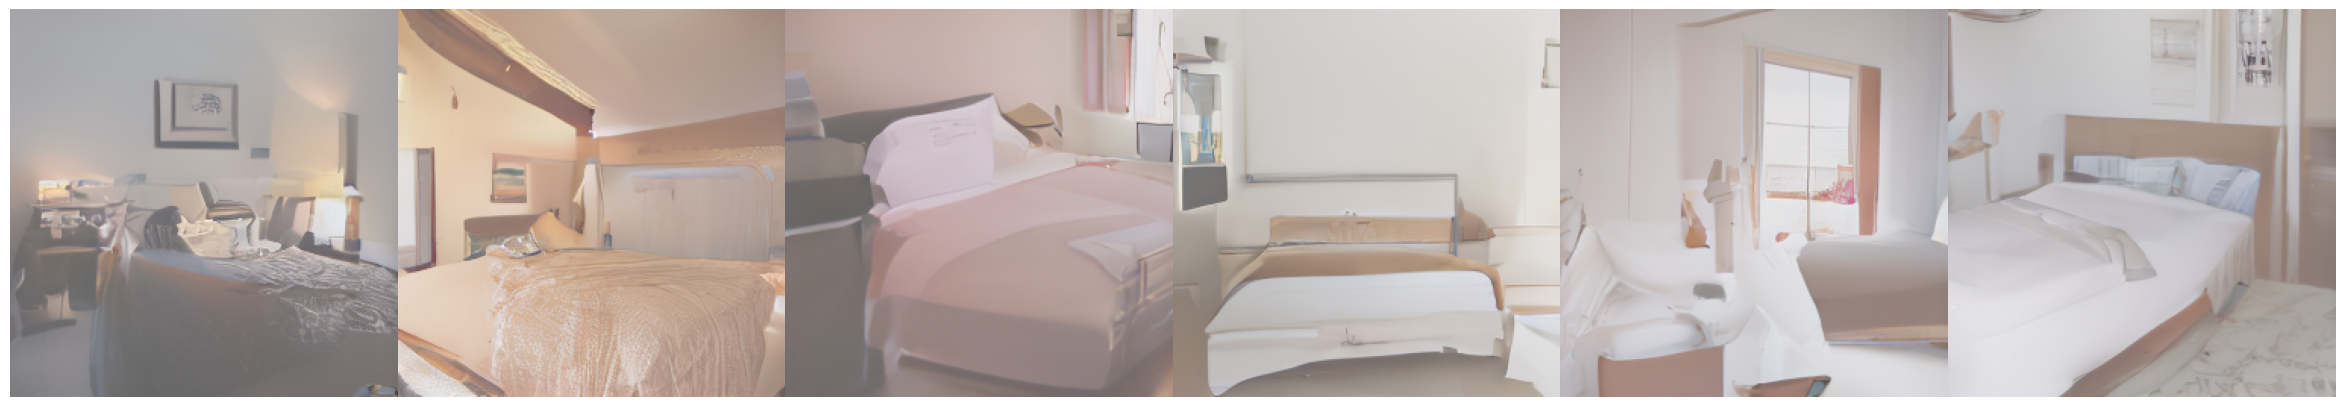

In [28]:
diffusion_model = DDPMPipeline.from_pretrained(
    "results/unet_hf_default/", use_safe_tensors=True
).to("cuda")
generate_sample_images(diffusion_model, 1000)

Keyword arguments {'use_safe_tensors': True} are not expected by DDPMPipeline and will be ignored.
100%|██████████| 100/100 [00:06<00:00, 15.63it/s]


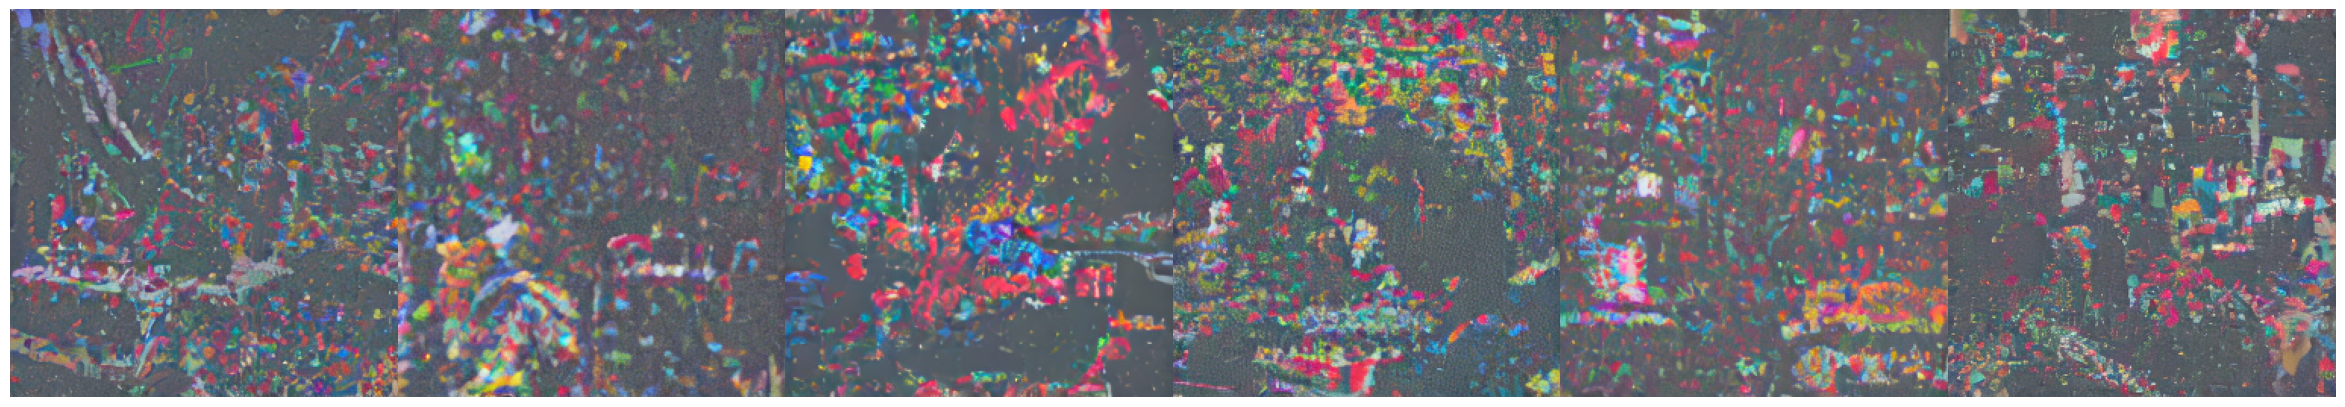

In [29]:
diffusion_model = DDPMPipeline.from_pretrained(
    "results/unet_hf_ddim/", use_safe_tensors=True
).to("cuda")
generate_sample_images(diffusion_model, 150)

Keyword arguments {'use_safe_tensors': True} are not expected by DDPMPipeline and will be ignored.
  0%|          | 0/30 [00:00<?, ?it/s]The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
 13%|█▎        | 4/30 [00:00<00:00, 36.09it/s]The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
The `scale_model_input` function should be called before `step` to ensure correct denoising. See 

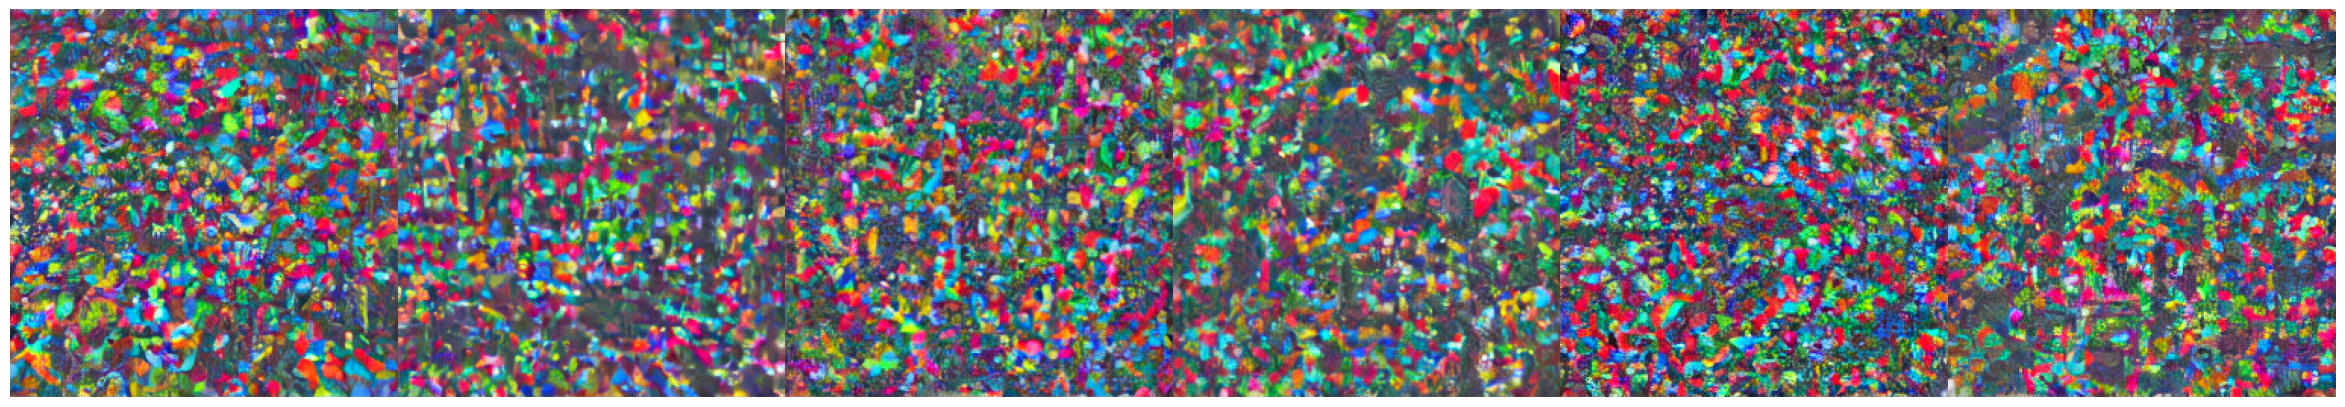

In [30]:
diffusion_model = DDPMPipeline.from_pretrained(
    "results/unet_hf_euler/", use_safe_tensors=True
).to("cuda")
generate_sample_images(diffusion_model, 30)

# Latent space smoothness

In [ ]:
diffusion_model = DDPMPipeline.from_pretrained(
    "results/unet_hf_default/", use_safe_tensors=True
).to("cuda")

In [19]:
seed1 = randn(size=(1, 3, 64, 64)).cuda()
seed2 = randn(size=(1, 3, 64, 64)).cuda()

In [ ]:
seeds = [
    ((1 - alpha) * seed1 + alpha * seed2)
    / np.sqrt(alpha**2 + (1 - alpha) ** 2)
    for alpha in np.linspace(0, 1, 10)
]
images = [
    generate_image(
        diffusion_model,
        1000,
        1,
        seed,
    )
    for seed in seeds
]

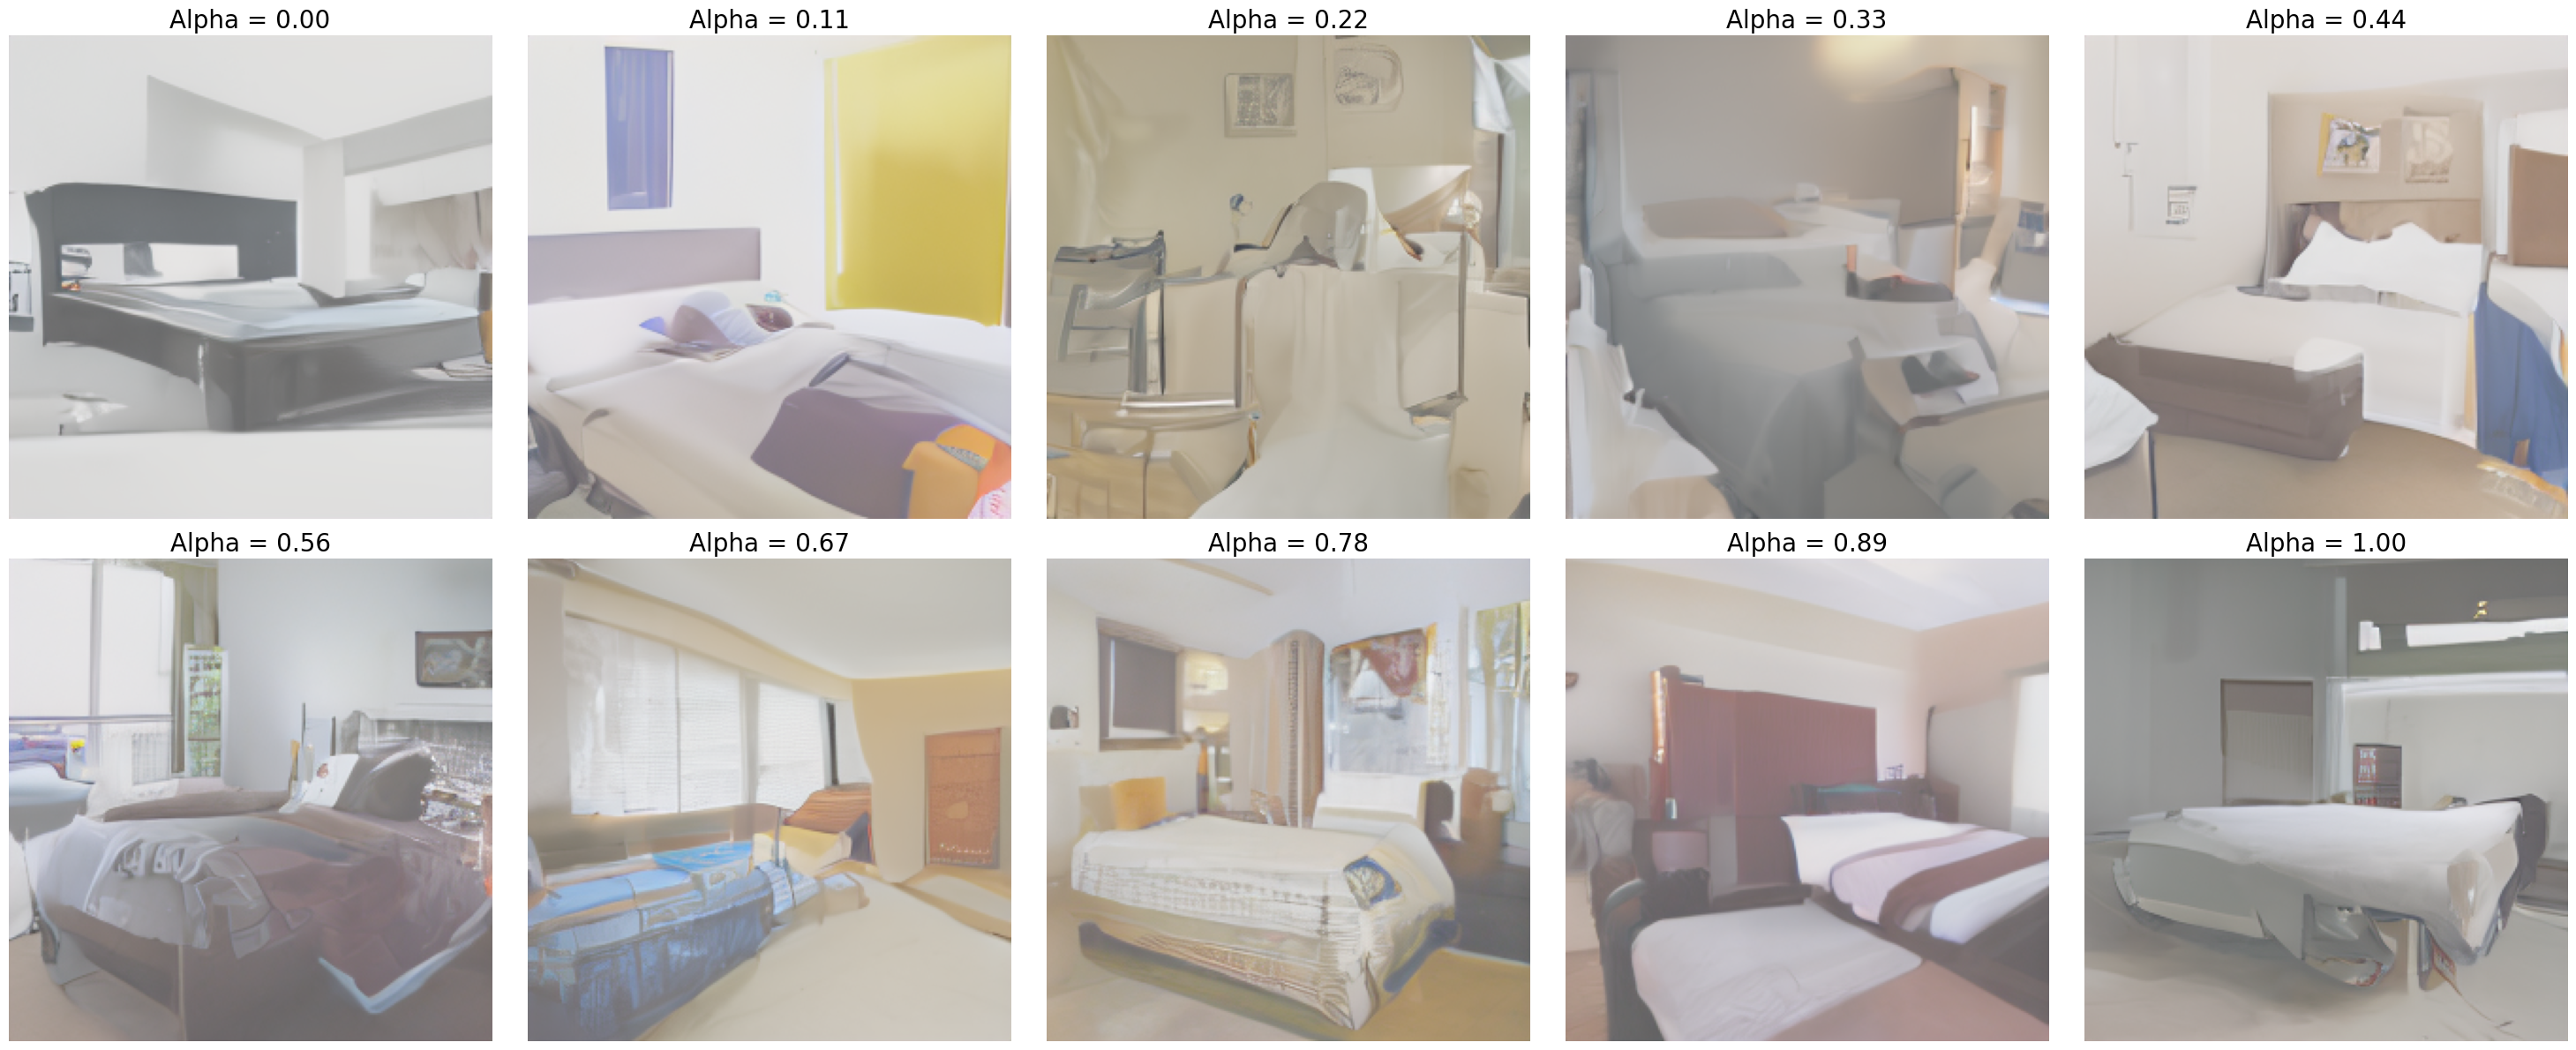

In [26]:
plt.rcParams["figure.figsize"] = (30, 12)
fig, ax = plt.subplots(nrows=2, ncols=5)
fig.subplots_adjust(wspace=0)
alphas = np.linspace(0, 1, 10)
for i in range(len(images)):
    ax[i // 5][i % 5].axis("off")
    ax[i // 5][i % 5].imshow(images[i][0])
    ax[i // 5][i % 5].set_title(f"Alpha = {alphas[i]:.2f}", fontsize=20)
fig.tight_layout()